In [1]:
words = open('names.txt','r').read().splitlines()

In [4]:
min(len(w) for w in words)

2

In [5]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs,chs[1:]):
        bigram = (ch1,ch2)
        b[bigram] = b.get(bigram,0) + 1

In [7]:
import torch

In [8]:
N = torch.zeros((27,27), dtype = torch.int32)

In [9]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [10]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1,ix2] +=1
        

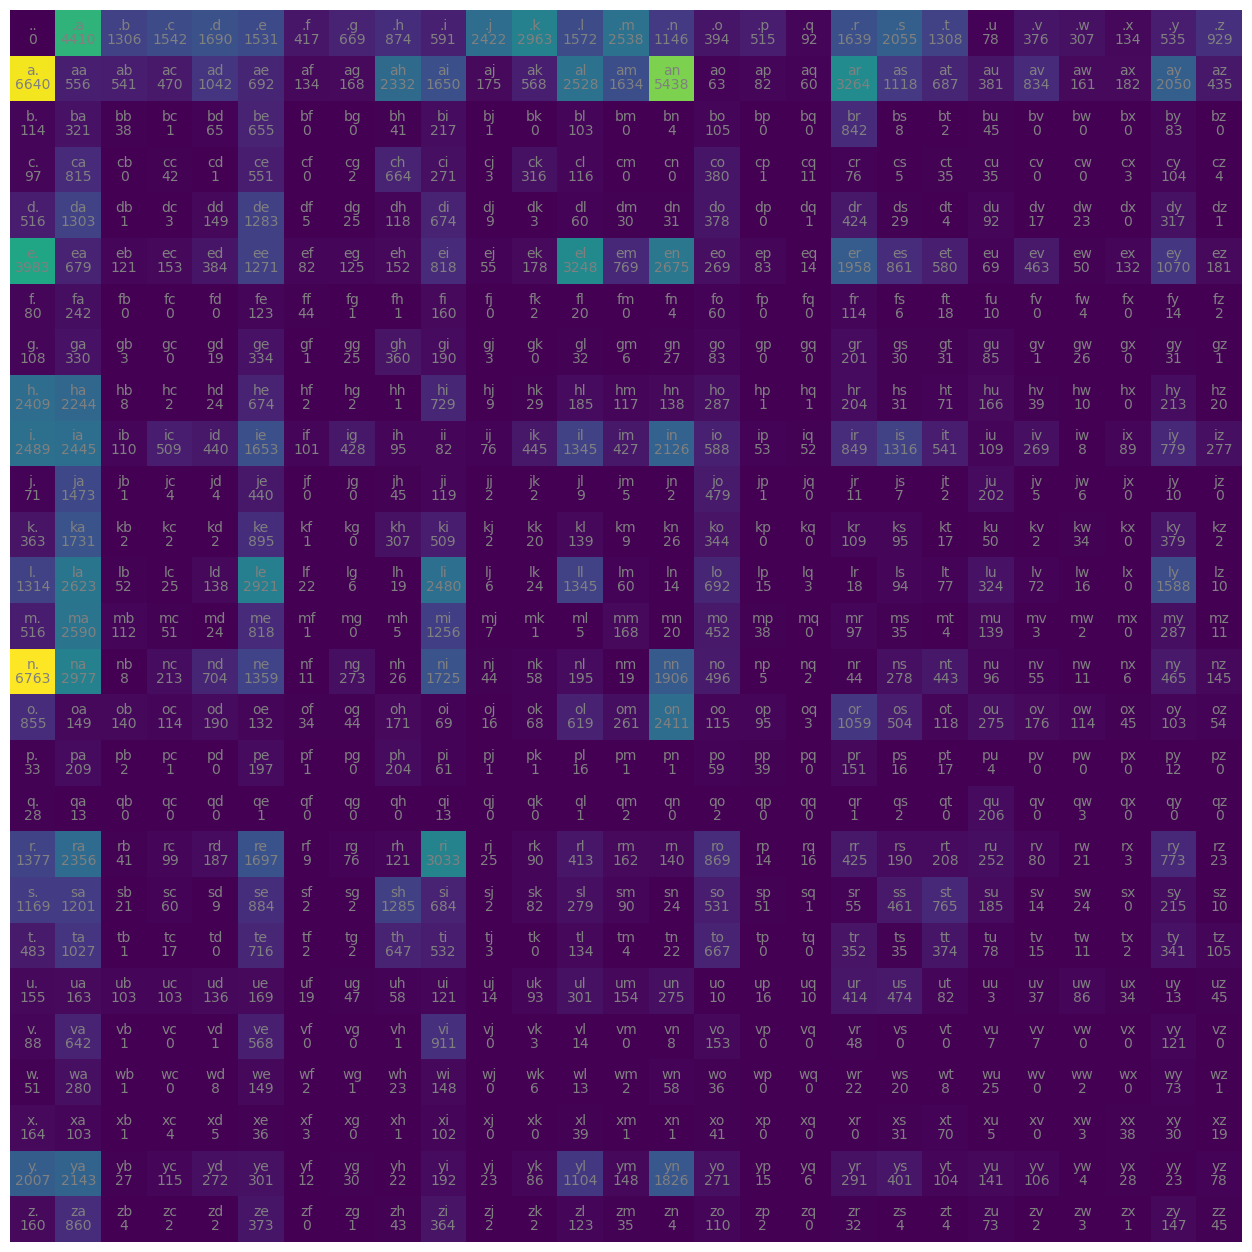

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (16,16))
plt.imshow(N)
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha = "center", va = "bottom", color = 'gray')
        plt.text(j,i, N[i,j].item(), ha = "center", va = "top", color = 'gray')
plt.axis('off');

In [16]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [25]:
p = N[0].float()
p = p/p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [26]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item()
itos[ix]

'j'

In [29]:
P = (N+1).float()
P /= P.sum(1, keepdims = True)

In [30]:
P.shape

torch.Size([27, 27])

In [31]:
P.sum(1, keepdim = True).shape

torch.Size([27, 1])

In [35]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        p  = P[ix]
        ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cony.
a.


## Maximizing Likelihood of the data

In [38]:
log_likelihood = 0.0
n = 0

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n +=1


In [40]:
print(f'{log_likelihood = }')
nll = -log_likelihood
print(f'{nll = }')
print(f'{nll/n = }')

log_likelihood = tensor(-559951.5625)
nll = tensor(559951.5625)
nll/n = tensor(2.4544)


In [41]:
xs , ys = [],[]

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1,ch2)
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [42]:
xs,ys

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

In [43]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes = 27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

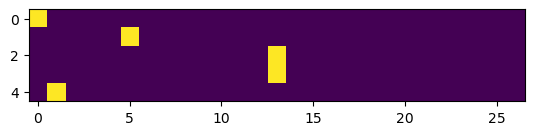

In [44]:
plt.imshow(xenc)

In [45]:
xenc.dtype

torch.float32

In [47]:
W = torch.randn((27,1))
xenc @ W

tensor([[ 1.7621],
        [-0.9187],
        [ 1.0101],
        [ 1.0101],
        [-0.8167]])

In [48]:
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdim = True)
probs

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [49]:
# Randomly initialize 27 neurons weights and each neurons recieves 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator = g)

In [50]:
xenc = F.one_hot(xs,num_classes = 27).float()
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims = True)

In [51]:
probs.shape

torch.Size([5, 27])

In [61]:
nlls = torch.zeros(5)
for i in range(5):
    x = xs[i].item()
    y = ys[i].item()
    print(f'{i+1}:{itos[x]}{itos[y]} for index {x},{y}')
    print('Input to nn : ',x)
    print('Output prob from nn : ', probs[i])
    p = probs[i,y]
    print('Output prob for y :',y)
    logp = torch.log(p)
    print('Log likelihood : ',logp.item())
    nll = -logp
    print('Negative log likelihood : ',nll.item())
    nlls[i] = nll

print()
print('Avg negative loglikelihood (loss) : ', nlls.mean().item())

1:.e for index 0,5
Input to nn :  0
Output prob from nn :  tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
Output prob for y : 5
Log likelihood :  -4.399273872375488
Negative log likelihood :  4.399273872375488
2:em for index 5,13
Input to nn :  5
Output prob from nn :  tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
Output prob for y : 13
Log likelihood :  -4.014570713043213
Negative log likelihood :  4.014570713043213
3:mm for index 13,13
Input to nn :  13
Output prob from nn :  tensor([0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
        0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 

In [62]:
xs, ys

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

In [63]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [75]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [76]:
print(loss.item())

3.7291626930236816


In [77]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [78]:
W.data += -0.1 * W.grad

In [83]:
# Optimization
xs,ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    num = xs.nelement()
    print('Number of examples : ', num)


Number of examples :  5


AttributeError: 'Tensor' object has no attribute 'append'

In [89]:
for k in range(1):
    
    # forward pass
    xenc = F.one_hot(xs, num_classes = 27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim = True)
    loss =  -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
    print(loss.item())

    W.grad = None
    loss.backward()

    W.data += -50 * W.grad

2.439082145690918


In [91]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes = 27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims = True)
        ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out))

ema.
ema.
ema.
ema.
ema.
